## Import Dataset
**uncomment the code at the begining**

In [ ]:
!pip install mediapipe

print("Downloading Dataset")
!curl http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip  --output AFLW2000-3D.zip

!unzip AFLW2000-3D.zip

## Importing liberary

In [2]:
import os
import gc
import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


import cv2
import mediapipe as mp


import math

from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

import scipy.io as sio

## Reading Data

# create Data for faceMish


**Read the Dataset and Create a facemish features to form a DataFrame and handling the missing values and empty files**
**we tried to convert the angle to to polar and train but the result was bad so we keep it**

In [43]:
def read_data(path='AFLW2000/'):
    dataset_dict = []

    files_name = glob.glob(path + '*.jpg')

    for img_path in files_name:

        label_path = img_path[:-3] + 'mat'

        if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
            label = sio.loadmat(label_path)["Pose_Para"][0][:3]
            dataset_dict.append({"image_name":img_path, 'pitch':label[0], 'yaw':label[1], 'roll':label[2]})



    dataset = pd.DataFrame(dataset_dict)

    return dataset

**Convert the image to RGB if needed while trying the gray scale one**

In [44]:
def convert_RGB(img):
    if img.ndim < 3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img

**Get the facemish and other spacified points to form the DataFrame**

In [45]:
def get_facemish(img):
    faceMesh_list = {}
    
    hight, width, _ = img.shape

    mp_face_mesh = mp.solutions.face_mesh

    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1,
                                            min_detection_confidence=0.5) as face_mesh_images:
        
        face_mesh_results = face_mesh_images.process(img)

        if face_mesh_results.multi_face_landmarks:

            for face_landmarks in face_mesh_results.multi_face_landmarks:
                for i, pt in enumerate(face_landmarks.landmark):
                    x = pt.x
                    y = pt.y
                    faceMesh_list.update({f"X {i}":x, f"Y {i}" :y})

    return faceMesh_list

**Merging the 2 function in one**

In [46]:
def multi_preprocessing(img):
    img = convert_RGB(img)
    
    return get_facemish(img)

**We call the create Dataframe function to call the multi_preprocessing and get the feature point and create the dataFrame**

In [47]:
def create_dataFrame(data_img):

    dataFrame = pd.DataFrame()
    
    for _, img in data_img.iterrows():
    
        image, *labels = img
        
        features = multi_preprocessing(plt.imread(image))

        features.update({'pitch':labels[0], 'yaw':labels[1], 'roll':labels[2], 'image_name':image})
        features = pd.Series(features)

        dataFrame = dataFrame.append(features, ignore_index=True)
        
    
    return dataFrame

### Normalize the face feature point with respect to the nose posetion to make it invariant to face size

In [48]:
def normalise_nose(df):

    # select columns whose names start with "X, Y" using filter() function
    X_features = df.filter(regex='^X')

    Y_features = df.filter(regex='^Y')


    # apply your function on the selected columns using apply() function
    X_normalized = X_features.apply(lambda x: x - X_features['X 1'])

    Y_normalized = Y_features.apply(lambda y: y - Y_features['Y 1'])


    # update the original DataFrame with the modified columns
    df[X_normalized.columns] = X_normalized

    df[Y_normalized.columns] = Y_normalized

    return df

In [49]:
df  = read_data()

In [50]:
train_df = create_dataFrame(df)

In [51]:
train_df.head()

,X 0,Y 0,X 1,Y 1,X 2,Y 2,X 3,Y 3,X 4,Y 4,...,X 465,Y 465,X 466,Y 466,X 467,Y 467,pitch,yaw,roll,image_name
0,0.485699,0.687087,0.489150,0.639948,0.489853,0.647495,0.479756,0.562636,0.490495,0.621423,...,0.541506,0.500291,0.665707,0.471219,0.676151,0.463839,-0.399231,0.018227,0.085676,AFLW2000\image00002.jpg
1,0.442459,0.642504,0.417327,0.592812,0.449168,0.611022,0.435618,0.544955,0.415644,0.577393,...,0.500206,0.514164,0.584079,0.499727,0.593786,0.494439,0.470065,1.189533,0.300959,AFLW2000\image00004.jpg
2,0.318026,0.799192,0.321820,0.776531,0.318601,0.782021,0.311447,0.746027,0.321967,0.767880,...,0.328722,0.723223,0.372980,0.712863,0.377189,0.709551,-0.184650,0.881137,-0.236852,AFLW2000\image00006.jpg
3,0.503904,0.694327,0.469415,0.654004,0.489449,0.658819,0.444337,0.590304,0.461645,0.637688,...,0.490581,0.518596,0.595712,0.455546,0.602776,0.444499,-0.175379,0.299208,-0.373374,AFLW2000\image00008.jpg
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.882169,1.198004,-1.033374,AFLW2000\image00010.jpg


**Some image mediaPipe can't get its features so we drop the null**

In [52]:
train_df.dropna(inplace=True)

In [53]:
train_df.shape

(1854, 940)

In [54]:
train_df = normalise_nose(train_df)
train_df.head()

,X 0,Y 0,X 1,Y 1,X 2,Y 2,X 3,Y 3,X 4,Y 4,...,X 465,Y 465,X 466,Y 466,X 467,Y 467,pitch,yaw,roll,image_name
0,-0.003452,0.047139,0.0,0.0,0.000702,0.007547,-0.009395,-0.077312,0.001345,-0.018525,...,0.052356,-0.139657,0.176557,-0.168729,0.187001,-0.176109,-0.399231,0.018227,0.085676,AFLW2000\image00002.jpg
1,0.025133,0.049692,0.0,0.0,0.031842,0.018210,0.018291,-0.047857,-0.001682,-0.015419,...,0.082880,-0.078648,0.166752,-0.093085,0.176460,-0.098373,0.470065,1.189533,0.300959,AFLW2000\image00004.jpg
2,-0.003794,0.022660,0.0,0.0,-0.003219,0.005490,-0.010373,-0.030505,0.000148,-0.008651,...,0.006902,-0.053308,0.051160,-0.063668,0.055369,-0.066981,-0.184650,0.881137,-0.236852,AFLW2000\image00006.jpg
3,0.034489,0.040323,0.0,0.0,0.020034,0.004815,-0.025078,-0.063699,-0.007770,-0.016316,...,0.021166,-0.135407,0.126297,-0.198458,0.133361,-0.209504,-0.175379,0.299208,-0.373374,AFLW2000\image00008.jpg
5,0.017556,0.064269,0.0,0.0,0.007057,0.019690,-0.025400,-0.062405,-0.004541,-0.020095,...,0.012831,-0.112081,0.109594,-0.152155,0.118412,-0.156283,-0.026812,0.011965,-0.220662,AFLW2000\image00013.jpg


In [55]:
train_df.to_csv("final_train.csv", index=False)


In [56]:
train_df = pd.read_csv('final_train.csv')
train_df.head()

,X 0,Y 0,X 1,Y 1,X 2,Y 2,X 3,Y 3,X 4,Y 4,...,X 465,Y 465,X 466,Y 466,X 467,Y 467,pitch,yaw,roll,image_name
0,-0.003452,0.047139,0.0,0.0,0.000702,0.007547,-0.009395,-0.077312,0.001345,-0.018525,...,0.052356,-0.139657,0.176557,-0.168729,0.187001,-0.176109,-0.399231,0.018227,0.085676,AFLW2000\image00002.jpg
1,0.025133,0.049692,0.0,0.0,0.031842,0.018210,0.018291,-0.047857,-0.001682,-0.015419,...,0.082880,-0.078648,0.166752,-0.093085,0.176460,-0.098373,0.470065,1.189533,0.300959,AFLW2000\image00004.jpg
2,-0.003794,0.022660,0.0,0.0,-0.003219,0.005490,-0.010373,-0.030505,0.000148,-0.008651,...,0.006902,-0.053308,0.051160,-0.063668,0.055369,-0.066981,-0.184650,0.881137,-0.236852,AFLW2000\image00006.jpg
3,0.034489,0.040323,0.0,0.0,0.020034,0.004815,-0.025078,-0.063699,-0.007770,-0.016316,...,0.021166,-0.135407,0.126297,-0.198458,0.133361,-0.209504,-0.175379,0.299208,-0.373374,AFLW2000\image00008.jpg
4,0.017556,0.064269,0.0,0.0,0.007057,0.019690,-0.025400,-0.062405,-0.004541,-0.020095,...,0.012831,-0.112081,0.109594,-0.152155,0.118412,-0.156283,-0.026812,0.011965,-0.220662,AFLW2000\image00013.jpg


# Model Stage

This is a function that trains a machine learning model on the given data using scikit-learn's MultiOutputRegressor class, which is a wrapper for a single regressor that can handle multiple target variables. The function takes in three parameters:

base_model: The underlying regressor model to be used, such as Linear Regression, Lasso, or Ridge.
X_train: The input feature variables to be used for training the model.
y_train: The target variables corresponding to X_train that the model aims to predict.
In the first line of the function, base_model is assigned to the variable svr. Then, MultiOutputRegressor is used to create a new regressor object mor that uses base_model as its internal regressor. The fit() method of the mor regressor is called on the training data X_train and y_train to train the model. Finally, the trained model mor is returned by the function.

In [57]:
def model_train(base_model,X_train, y_train):
    # Create the Model regressor
    svr = base_model
    # Create the Multioutput Regressor
    mor = MultiOutputRegressor(base_model)
    # Train the regressor
    mor = mor.fit(X_train, y_train)
    return mor

This is a function that generates predictions for the testing data using the trained model. The function takes in two parameters:

model: The trained machine learning model that will be used to generate predictions.
X_val: The input feature variables for the validation dataset that the model will be used to predict the target variable for.
The predict() method of the model object is called on the validation feature data X_val to generate the predictions for the target variable. These predictions are returned as the output of the function.

In [58]:
def model_predict(model,X_val):
  # Generate predictions for testing data
  return model.predict(X_val)

This is a function that evaluates the performance of a trained machine learning model by calculating the mean squared error (MSE) and mean absolute error (MAE) for each target variable in the validation dataset. The function takes in two parameters:

y_val: The actual target variables for the validation dataset.
y_pred: The predicted target variables for the validation dataset.
The function first calculates the MSE and MAE for each target variable by calling the mean_squared_error() and mean_absolute_error() functions from the scikit-learn library. The first argument for each of these functions is the actual target variable for the specific target column in the validation dataset, and the second argument is the predicted target variable for the same target column. The calculated MSE and MAE for each target variable are stored in the variables mse_one, mae_one, mse_two, mae_two, mse_third, and mae_third.

The function then prints out the calculated MSE and MAE for each target variable in a human-readable format. The output includes the MSE and MAE for each of the three target variables, with the target variables labeled as the first, second, and third regressor.

In [59]:
def evaluate_model(y_val, y_pred):
    # Evaluate the regressor
    mse_one = mean_squared_error(y_val.iloc[:,0], y_pred[:,0])
    mse_two = mean_squared_error(y_val.iloc[:,1], y_pred[:,1])
    mse_third = mean_squared_error(y_val.iloc[:,2], y_pred[:,2])
    print(f'MSE for first regressor: {mse_one} - second regressor: {mse_two} - Thrid regressor: {mse_third}')
    mae_one = mean_absolute_error(y_val.iloc[:,0], y_pred[:,0])
    mae_two = mean_absolute_error(y_val.iloc[:,1], y_pred[:,1])
    mae_third = mean_absolute_error(y_val.iloc[:,2], y_pred[:,2])
    print(f'MAE for first regressor: {mae_one} - second regressor: {mae_two} - Thrid regressor: {mae_third}')

In [60]:
#Train
train_df.drop(['image_name'], axis = 1, inplace = True)
X = train_df.iloc[:,:-3]
y = train_df.iloc[:,-3:] 

In [61]:
#Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=33)

# LinearRegression

To establish a baseline model, we utilized linear regression. However, the results were unsatisfactory and the model appeared to be overfitting the data. Consequently, we decided to explore other models to improve the performance. To that end, we examined the effectiveness of Lasso and Ridge models.

In [62]:
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)

In [63]:
reg = LinearRegression()
multi_reg = model_train(reg,X_train_std, y_train)

In [64]:
# Create the Multioutput Regressor
y_pred = model_predict(multi_reg, X_val_std)
evaluate_model(y_val, y_pred)

MSE for first regressor: 0.48350345938637374 - second regressor: 0.08415366971078136 - Thrid regressor: 0.2674762631851598
MAE for first regressor: 0.3298580496193222 - second regressor: 0.1965866114272592 - Thrid regressor: 0.3022119531042025


In [65]:
y_pred_train = model_predict(multi_reg, X_train_std)
evaluate_model(y_train, y_pred_train)

MSE for first regressor: 0.015619950071530343 - second regressor: 0.007948736509907931 - Thrid regressor: 0.01526612471257049
MAE for first regressor: 0.09651022980466784 - second regressor: 0.06352893441303328 - Thrid regressor: 0.09177044126373564


Initially, we used Linear Regression as the baseline model, but the results were not very good, and the model was overfitting. So, we decided to use Lasso and Ridge, which helped to reduce overfitting. However, the model's performance was still not satisfactory. Therefore, we decided to use standard scaling to preprocess the data, hoping to improve accuracy.

## Ridge

In [66]:
clf = Ridge(alpha=0.1, tol = 1e-4)
multi_clf = model_train(clf,X_train, y_train)
# Generate predictions for testing data
y_pred = model_predict(multi_clf,X_val)
evaluate_model(y_val, y_pred)

MSE for first regressor: 0.1361706409292237 - second regressor: 0.016445832255705145 - Thrid regressor: 0.1621473304689493
MAE for first regressor: 0.12337417647891517 - second regressor: 0.08018525276881318 - Thrid regressor: 0.1634811288121667


In [67]:
y_pred_train = model_predict(multi_clf,X_train)
evaluate_model(y_train, y_pred_train)

MSE for first regressor: 0.290093899159002 - second regressor: 0.05621287000402126 - Thrid regressor: 0.32294136698254555
MAE for first regressor: 0.13496774715890708 - second regressor: 0.10242326517705093 - Thrid regressor: 0.1632385100371764


#  Lasso

In [68]:
lasso = Lasso(alpha=0.2, tol = 1e-5)
multi_clf_lasso = model_train(lasso,X_train_std, y_train)

In [69]:
# Create the Multioutput Regressor
y_pred = model_predict(multi_clf_lasso,X_val_std)
evaluate_model(y_val, y_pred)

MSE for first regressor: 0.14810335218368514 - second regressor: 0.06865956028335772 - Thrid regressor: 0.14767108716956434
MAE for first regressor: 0.18941937207447387 - second regressor: 0.16049937604030348 - Thrid regressor: 0.13915031450669327


In [70]:
# Create the Multioutput Regressor
y_pred_train = model_predict(multi_clf_lasso,X_train_std)
evaluate_model(y_train, y_pred_train)

MSE for first regressor: 0.3505012275466951 - second regressor: 0.11276553502777385 - Thrid regressor: 0.41736497380961884
MAE for first regressor: 0.21366443126510387 - second regressor: 0.17964723380838307 - Thrid regressor: 0.15168968155963586



# Normalization are important for model such as Ridge & Lasso

After applying standard scaling to preprocess the data, we observed a slight decrease in the mean absolute error, but the model's performance was still not satisfactory. Therefore, we decided to use Support Vector Machines (SVM) for the next step of our solution.

In [71]:
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)

In [72]:
# Create the Ridge regressor
clf_n = Ridge(alpha=0.2, tol = 1e-4)
multi_clf_n =  model_train(clf,X_train_std, y_train)
# Create the Multioutput Regressor
y_pred =model_predict(multi_clf_n,X_val_std)
evaluate_model(y_val, y_pred)

MSE for first regressor: 0.21279597174630593 - second regressor: 0.021092109322207366 - Thrid regressor: 0.20340993091916543
MAE for first regressor: 0.1846777982031816 - second regressor: 0.09756691728701503 - Thrid regressor: 0.22810042659333535


In [73]:
# Create the Ridge regressor
Lasso_n = Lasso(alpha=0.2, tol = 1e-4)
multi_Lasso_n =  model_train(Lasso_n ,X_train_std, y_train)
# Create the Multioutput Regressor
y_pred =model_predict(multi_Lasso_n,X_val_std)
evaluate_model(y_val, y_pred)

MSE for first regressor: 0.14810335218368514 - second regressor: 0.06866254878567718 - Thrid regressor: 0.14766955374098947
MAE for first regressor: 0.18941937207447387 - second regressor: 0.1605015448242217 - Thrid regressor: 0.13914781171864934


# SVM

For the next step in our analysis, we will use Support Vector Machines (SVM) with the radial basis function (RBF) kernel. This choice is based on the fact that the RBF kernel is capable of capturing complex, nonlinear relationships between input features and output targets. Additionally, the RBF kernel has a local nature, which means that it only considers nearby points in the feature space when making predictions. This property allows it to handle high-dimensional data effectively

In [74]:
# Create the SVR regressor
svr = SVR()
svr = model_train(svr,X_train, y_train)

In [75]:
# Create the Multioutput Regressor
y_pred =model_predict(svr,X_val)
evaluate_model(y_val, y_pred)

MSE for first regressor: 0.11887540566526163 - second regressor: 0.01206745417938321 - Thrid regressor: 0.1304682770242424
MAE for first regressor: 0.0980016876764528 - second regressor: 0.06302759742017414 - Thrid regressor: 0.07643389345441091


Normalization are important for model such as SVM

In [76]:
# Create the SVR regressor
svrn = SVR()
svrn = model_train(svrn,X_train_std, y_train)

In [77]:
# Create the Multioutput Regressor
y_pred =model_predict(svrn,X_val_std)
evaluate_model(y_val, y_pred)

MSE for first regressor: 0.12030577148920273 - second regressor: 0.012006977895257223 - Thrid regressor: 0.13246570657683968
MAE for first regressor: 0.10083724257425755 - second regressor: 0.06972732619570149 - Thrid regressor: 0.08133431559865023


We found that applying Standard Scale did not have a significant impact on the performance of our SVM model. The model was able to achieve a satisfactory level of accuracy. However, for the next iteration of our analysis, we plan to explore tree-based models as they may provide a different perspective and potentially lead to further improvements in performance.

# Try Non-Linear Models

Why Extra Tree ?
Extra Trees not only randomly select the subset of features to split on at each node, but also use random thresholds for the splitting. This makes the trees more random and therefore more diverse, which can help to reduce overfitting and improve generalization.

in addition to Extra Trees can be particularly useful when dealing with high-dimensional datasets this is perfect in our situation.


In [78]:
# Create the Etra regressor
etra = ExtraTreesRegressor()
# Create the Multioutput Regressor
etra = model_train(etra,X_train, y_train)

In [79]:
# Generate predictions for testing data
y_pred = model_predict(etra,X_val)

In [80]:
evaluate_model(y_val, y_pred)

MSE for first regressor: 0.3457157629352173 - second regressor: 0.033822608693491976 - Thrid regressor: 0.4451662723571256
MAE for first regressor: 0.14734835246377315 - second regressor: 0.07786276856380575 - Thrid regressor: 0.11791809484860996


Result Navie ExtraTreesRegressor it's seem accuracy as svm in validation try optimze the result on the bad esimator.

In [81]:
# Create the Etra regressor
etra = ExtraTreesRegressor()
param_grid = {
    'n_estimators': [50,100,300],
    'criterion': ['squared_error', 'absolute_error','friedman_mse', 'poisson'],
    'max_depth': [2,8,16,32,50],
    'max_features': ['auto','sqrt','log2'],    
    'bootstrap': [True, False],
}


In [82]:
gcv = RandomizedSearchCV(etra,param_grid,n_jobs=-1).fit(X_train, y_train.iloc[:,0])

In [83]:
# Create the Etra regressor
best_etra = gcv.best_estimator_  
# Train the regressor
morextr = model_train(best_etra,X_train, y_train)

In [84]:
# Generate predictions for testing data
y_pred = model_predict(morextr, X_val)
evaluate_model(y_val, y_pred)

MSE for first regressor: 0.1352833234791707 - second regressor: 0.030764972823884754 - Thrid regressor: 0.14146367842963686
MAE for first regressor: 0.1444936499209394 - second regressor: 0.11571015104216542 - Thrid regressor: 0.15003954851381124


Finally we will try use xgb

why xgb?

popular tree-based ensemble model that uses gradient boosting algorithm. It is known for its high accuracy, speed and performance in large datasets, and ability to handle missing values, making it a popular choice for machine learning tasks. Additionally, XGBRegressor has a number of tunable hyperparameters that can be adjusted to optimize performance, which can make it a powerful tool for improving the accuracy of regression models.

our result almost see as SVR

# xgb

In [85]:
xg = xgb.XGBRegressor(random_state=42)

In [86]:
multi_xg = model_train( xg,X_train, y_train)

In [87]:
# Create the Multioutput Regressor
y_pred = model_predict(multi_xg, X_val)
evaluate_model(y_val, y_pred)

MSE for first regressor: 0.5272059378067118 - second regressor: 0.12627696590500903 - Thrid regressor: 0.4886777621549199
MAE for first regressor: 0.14585931524348814 - second regressor: 0.0966081212926154 - Thrid regressor: 0.11353331774751992


We may want to consider using PCA on our models as our data has high dimensionality. PCA can help reduce the dimensionality of our feature space, allowing us to simplify our models and potentially improve their performance. By using PCA, we can identify the most important components that capture the most variation in our data and only keep those components for training our models, which can lead to better accuracy, faster training time, and less overfitting. However, it's worth noting that PCA can also result in loss of information, so it's important to carefully choose the number of components to keep and evaluate the impact on model performance

# Using PCA

In [88]:
pca = PCA(n_components= 0.99)
pca.fit(X_train_std)

PCA(n_components=0.99)

In [89]:
train = pca.transform(X_train_std)
test = pca.transform(X_val_std)

In [90]:
train.shape

(1483, 7)

In [91]:
# Create the Ridge regressor
clf_n = Ridge(alpha=0.1, tol = 1e-4)
multi_clf_n = model_train(clf_n,train, y_train)

In [92]:
# Generate predictions for testing data
y_pred = model_predict(multi_clf_n,test)

In [93]:
evaluate_model(y_val, y_pred)

MSE for first regressor: 0.12579648744532052 - second regressor: 0.02913881154810364 - Thrid regressor: 0.15124727609747457
MAE for first regressor: 0.11811263793105023 - second regressor: 0.11791127550893984 - Thrid regressor: 0.14702144033786482


Linear

In [94]:
reg = LinearRegression()
multi_reg = model_train(reg,train, y_train)

In [95]:
# Generate predictions for testing data
y_pred = model_predict(multi_reg,test)
evaluate_model(y_val, y_pred)

MSE for first regressor: 0.12579648660181156 - second regressor: 0.029138806107966174 - Thrid regressor: 0.15124733572146132
MAE for first regressor: 0.1181126468714062 - second regressor: 0.11791128134744851 - Thrid regressor: 0.1470215989411869


EXtra Tree

In [96]:
# Create the Etra regressor
etra = ExtraTreesRegressor()
# Create the Multioutput Regressor
etra = model_train(etra,train, y_train)

In [97]:
# Generate predictions for testing data
y_pred = model_predict(etra,test)
evaluate_model(y_val, y_pred)

MSE for first regressor: 0.1815300290438273 - second regressor: 0.028634237273992395 - Thrid regressor: 0.3837715245905265
MAE for first regressor: 0.1278134193184645 - second regressor: 0.07429417234658765 - Thrid regressor: 0.12316859265231456


Lasso with PCA

In [98]:
lasso = Lasso(alpha=0.2, tol = 1e-5)
multi_clf_lasso1 = model_train(lasso,train, y_train)

In [99]:
# Generate predictions for testing data
y_pred = model_predict(multi_clf_lasso1,test)

In [100]:
evaluate_model(y_val, y_pred)

MSE for first regressor: 0.12757766602157308 - second regressor: 0.03051401851771512 - Thrid regressor: 0.14413215387744738
MAE for first regressor: 0.12007814152909187 - second regressor: 0.11976122127370428 - Thrid regressor: 0.12983896144535056


XGBOOST with PCA

In [101]:
xg = xgb.XGBRegressor(random_state=42)
multi_xg = model_train( xg,train, y_train)

In [102]:
# Generate predictions for testing data
y_pred = model_predict(multi_xg,test)
evaluate_model(y_val, y_pred)

MSE for first regressor: 0.3063239907442858 - second regressor: 0.016698722211344892 - Thrid regressor: 1.4182959989488049
MAE for first regressor: 0.13840581419249504 - second regressor: 0.07943705044940334 - Thrid regressor: 0.17393321084181654


    SVR With PCA

In [103]:
svr_pca = SVR()
multi_svr_pca = model_train( svr_pca,train, y_train)

In [105]:
# Generate predictions for testing data
y_pred = model_predict(multi_svr_pca,test)
evaluate_model(y_val, y_pred)

MSE for first regressor: 0.12123246228866742 - second regressor: 0.012336476962170677 - Thrid regressor: 0.1327945134977274
MAE for first regressor: 0.10383843064339275 - second regressor: 0.06964454700541187 - Thrid regressor: 0.08098357221802185


As a conclusion, using PCA to reduce the dimensionality of the data to only 7 components, did not lead to a decrease in accuracy in most cases. This approach can be useful when working with high-dimensional data, as it can help to reduce the computational cost and potentially improve the performance of the model. However, it is important to note that the optimal number of components to use may vary depending on the specific problem and data set, and it may require some experimentation to find the best approach.


# Make Model Pipeline

We continued our analysis by exploring the combination of PCA and SVR, and found that using PCA with SVR resulted in the best accuracy for most models. This approach allowed us to reduce the dimensionality of the data while maintaining high accuracy, demonstrating the effectiveness of this technique in improving the performance of our models.

In [106]:
# Create the SVR regressor
svr = SVR()
svr = model_train(svr,X_train, y_train)
# Create the Multioutput Regressor
y_pred = model_predict(svr,X_val)
evaluate_model(y_val, y_pred)

MSE for first regressor: 0.11887540566526163 - second regressor: 0.01206745417938321 - Thrid regressor: 0.1304682770242424
MAE for first regressor: 0.0980016876764528 - second regressor: 0.06302759742017414 - Thrid regressor: 0.07643389345441091


In [107]:
pipe = Pipeline([('scaler', StandardScaler()),('pca',PCA(n_components= 0.99)), ('svr', SVR())])

In [108]:
morsvr = model_train(pipe,X_train, y_train)

In [109]:
y_pred = model_predict(morsvr,X_val)
evaluate_model(y_val, y_pred)

MSE for first regressor: 0.12123246228866742 - second regressor: 0.012336476962170656 - Thrid regressor: 0.13279451349772745
MAE for first regressor: 0.10383843064339299 - second regressor: 0.0696445470054118 - Thrid regressor: 0.08098357221802191


# Draw

This function takes in Euler angles (roll, yaw, pitch) and returns a 3x3 rotation matrix that represents the same rotation as the Euler angles. The rotation matrix is obtained by computing the product of three separate rotation matrices, one for each Euler angle, which are constructed using trigonometric functions.

The resulting rotation matrix can be used to transform a 3D object, such as an image or point cloud, to the orientation specified by the input Euler angles.

In [32]:
def EulerToMatrix(roll, yaw, pitch):
    # roll - z axis
    # yaw  - y axis
    # pitch - x axis
    roll = roll / 180 * np.pi
    yaw = yaw / 180 * np.pi
    pitch = pitch / 180 * np.pi

    Rz = [[math.cos(roll), -math.sin(roll), 0],
          [math.sin(roll), math.cos(roll), 0],
          [0, 0, 1]]

    Ry = [[math.cos(yaw), 0, math.sin(yaw)],
          [0, 1, 0],
          [-math.sin(yaw), 0, math.cos(yaw)]]

    Rx = [[1, 0, 0],
          [0, math.cos(pitch), -math.sin(pitch)],
          [0, math.sin(pitch), math.cos(pitch)]]

    matrix = np.matmul(Rx, Ry)
    matrix = np.matmul(matrix, Rz)

    return matrix

The draw_axis function is used to draw a set of 3D axes on an input image, with the orientation of the axes determined by the input pitch, yaw, and roll angles. The function takes in the following parameters:

img: The input image on which to draw the axes.
pitch: The pitch angle in degrees.
yaw: The yaw angle in degrees.
roll: The roll angle in degrees.
tdx: The x-coordinate of the center point of the axes. If not provided, the center of the image is used.
tdy: The y-coordinate of the center point of the axes. If not provided, the center of the image is used.
size: The length of the axes to be drawn in pixels.
The function first adjusts the input yaw value by negating it, and then calculates the 3D coordinates of the endpoints of the three axes using the input pitch, yaw, and roll angles. The function then draws the three axes on the input image using OpenCV's cv2.line function, with red representing the x-axis, green representing the y-axis, and blue representing the z-axis.

The function returns the input image with the 3D axes drawn on it.

In [33]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (math.cos(yaw) * math.cos(roll)) + tdx
    y1 = size * (math.cos(pitch) * math.sin(roll) + math.cos(roll) * math.sin(pitch) * math.sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-math.cos(yaw) * math.sin(roll)) + tdx
    y2 = size * (math.cos(pitch) * math.cos(roll) - math.sin(pitch) * math.sin(yaw) * math.sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (math.sin(yaw)) + tdx
    y3 = size * (-math.cos(yaw) * math.sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

# Position Nose

In [ ]:
!curl  'https://raw.githubusercontent.com/adobe/SimpleSensor/master/simplesensor/collection_modules/demographic_camera/classifiers/haarcascades/haarcascade_mcs_nose.xml' > haarcascade_mcs_nose.xml


This function takes an image as input and detects the position of the nose in the image. It returns the x and y coordinates of the center of the nose.


**But we replace it using the media pipe feature point of the nose**

In [ ]:
"""def position_nose(img):
  # Load the Haar cascade classifier XML file
  nose_cascade = cv2.CascadeClassifier("/content/haarcascade_mcs_nose.xml")
  if nose_cascade.empty():
    return 0,0
  img = convert_RGB(img)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  nose_rects = nose_cascade.detectMultiScale(gray, 1.3, 5)
  for (x,y,w,h) in nose_rects:
    return int((x+x+w)/2), int((y+y+h)/2)
  return 0,0"""

# Test

In [119]:
def imge_prediction(img, model):

    if type(img) is str:
        img = plt.imread(img)
    
    list_mesh = multi_preprocessing(img)
    df = pd.DataFrame(pd.Series(list_mesh))
    
    if df.empty == True:
        return img
    
    nose_x, nose_y = df.T['X 1'][0], df.T['Y 1'][0]
    
    list_mesh = normalise_nose(df.T)
     
    
    if list_mesh.shape[1] == model.n_features_in_:
        y_pred = model.predict(list_mesh)
        
        if list_mesh['X 1'][0] is not None:
            
                img = convert_RGB(img)   
                return draw_axis(img, y_pred[0][0], y_pred[0][1], y_pred[0][2], tdx=nose_x*img.shape[1], tdy=nose_y*img.shape[0], size=100)

    return img


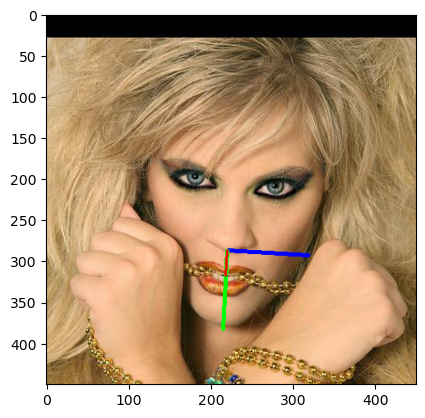

In [117]:
plt.imshow(imge_prediction('AFLW2000/image00002.jpg', morsvr))


# video

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#!cp '/content/drive/MyDrive/dataset/WhatsApp Video 2023-02-19 at 8.19.33 PM.mp4'  "/content/uploaded.mp4"

In [124]:
video_path = "FINAL-VIDEO.mp4"

cap = cv2.VideoCapture(video_path)

rotateCode = False

video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

video_fps = cap.get(cv2.CAP_PROP_FPS)

out = cv2.VideoWriter("final.mp4", fourcc=cv2.VideoWriter_fourcc(*'mp4v'), fps=int(video_fps), frameSize=(video_width, video_height))

# Check if the video is opened successfully
if not cap.isOpened():

    print("Error opening video file")

# Read the frames of the video
while True:
    ret, frame = cap.read()

    # Break the loop if the video is over
    if not ret:
        break

    
    if rotateCode:
         frame = cv2.rotate(frame, cv2.ROTATE_180)

    
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    
    result = imge_prediction(frame, morsvr)

    if type(result) is type(None):
        continue

    
    frame = np.uint8(result)
    
    out.write(frame)
    # Break the loop if the user presses "q"
    if cv2.waitKey(25) & 0xFF == ord("q"):
        break

# Release the video capture object and destroy all windows
out.release()
cap.release()
#cv2.destroyAllWindows()


# Run Time video

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time


In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV RGB image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV RGB image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """

  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGB')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():

    js = Javascript('''
        var video;
        var div = null;
        var stream;
        var captureCanvas;
        var imgElement;
        var labelElement;
        
        var pendingResolve = null;
        var shutdown = false;
        
        
        function onAnimationFrame() {
            if (!shutdown) {
                window.requestAnimationFrame(onAnimationFrame);
            }
            if (pendingResolve) {

                var result = "";

                if (!shutdown) {
                    captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
                    result = captureCanvas.toDataURL('image/jpeg', 0.8)
                }

                var lp = pendingResolve;

                pendingResolve = null;
                lp(result);
            }
        }
        
        async function createDom() {
            if (div !== null) {
                return stream;
            }

            div = document.createElement('div');
            div.style.border = '2px solid black';
            div.style.padding = '3px';
            div.style.width = '100%';
            div.style.maxWidth = '600px';
            document.body.appendChild(div);
            
            const modelOut = document.createElement('div');
            modelOut.innerHTML = "<span>Status:</span>";
            labelElement = document.createElement('span');
            labelElement.innerText = 'No data';
            labelElement.style.fontWeight = 'bold';
            modelOut.appendChild(labelElement);
            div.appendChild(modelOut);
                
            video = document.createElement('video');
            video.style.display = 'block';
            video.width = div.clientWidth - 6;
            video.setAttribute('playsinline', '');
            video.onclick = () => { shutdown = true; };
            stream = await navigator.mediaDevices.getUserMedia(
                        {video: {facingMode: "environment"}}
                    );
            div.appendChild(video);

            imgElement = document.createElement('img');
            imgElement.style.position = 'absolute';
            imgElement.style.zIndex = 1;
            imgElement.onclick = () => { shutdown = true; };
            div.appendChild(imgElement);
            
            const instruction = document.createElement('div');
            instruction.innerHTML = 
                '<span style="color: red; font-weight: bold;">' +
                'When finished, click here or on the video to stop this demo</span>';
            div.appendChild(instruction);
            instruction.onclick = () => {shutdown = true;};
            
            video.srcObject = stream;
            await video.play();

            captureCanvas = document.createElement('canvas');
            captureCanvas.width = 640; //video.videoWidth;
            captureCanvas.height = 480; //video.videoHeight;
            window.requestAnimationFrame(onAnimationFrame);
            
            return stream;
        }

        function removeDom() {
            stream.getVideoTracks()[0].stop();
            video.remove();
            div.remove();
            video = null;
            div = null;
            stream = null;
            imgElement = null;
            captureCanvas = null;
            labelElement = null;
        }

        async function stream_frame(label, imgData) {
            if (shutdown) {
                removeDom();
                shutdown = false;
                return '';
            }

            var preCreate = Date.now();
            stream = await createDom();
            
            var preShow = Date.now();

            if (label != "") {
                labelElement.innerHTML = label;
            }
                    
            if (imgData != "") {
                var videoRect = video.getClientRects()[0];
                imgElement.style.top = videoRect.top + "px";
                imgElement.style.left = videoRect.left + "px";
                imgElement.style.width = videoRect.width + "px";
                imgElement.style.height = videoRect.height + "px";
                imgElement.src = imgData;
            }
            
            var preCapture = Date.now();
            var result = await new Promise(function(resolve, reject) {
                        pendingResolve = resolve;
                    }
            );
            shutdown = false;
            
            return {'create': preShow - preCreate, 
                    'show': preCapture - preShow, 
                    'capture': Date.now() - preCapture,
                    'img': result};
        }

    ''')

    display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
frames = np.empty(shape=(0,480,640,3))
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''

while True:
    js_reply = video_frame(label_html, bbox)

    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])


    result = imge_prediction(img, morsvr)



    if  result:
        frames = np.append(frames, np.expand_dims(result, axis=0), axis=0)
        res_bytes = bbox_to_bytes(result)
        # update bbox so next frame gets new overlay
        bbox = res_bytes

In [ ]:
height, width = frames.shape[1:3]
print(f"number of frames: {frames.shape[0]} and width: {width} and height: {height}")

In [ ]:
out = cv2.VideoWriter("videoStream.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 1, (width, height))
for frame in frames:
    
    frame = np.uint8(frame)
    out.write(frame) 
out.release()